In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random

In [2]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [3]:
input_size = 2
hidden_size = 12
output_size = 2

class TwoLayerMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(TwoLayerMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [4]:
epochs = 10000
learning_rate = 0.01

# Random Labels

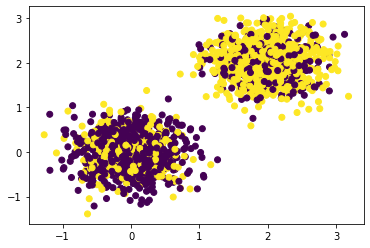

In [5]:
n_samples_1 = 1000
n_samples_2 = 1000
centers = [[0.0, 0.0], [2.0, 2.0]]
clusters_std = [0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Randomly flip a percentage of labels
percent = 0.3
n = len(y)
y_orig = np.array(list(y))
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y_orig = y_orig.reshape(-1, 1)
y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels_orig = torch.tensor(y_orig, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

## Inverted CVaR

In [6]:
class CVaRLoss(nn.Module):
    def __init__(self, a=0.05, inverted=False, criterion=nn.CrossEntropyLoss(reduction='none'), reduction='mean'):
        super().__init__()
        self.a = a
        self.inverted = inverted
        self.criterion = criterion
        self.reduction = reduction
    
    def _value_at_risk(self, loss):
        sorted_loss, sorted_indices = torch.sort(loss, dim=0, descending=False, stable=True)
        empirical_cdf = torch.argsort(sorted_indices) / len(loss)
        sorted_cdf, _ = torch.sort(empirical_cdf, dim=0, descending=False, stable=True)
        value_at_risk_idx = np.searchsorted(sorted_cdf, 1 - self.a, side='left')
        return sorted_loss[value_at_risk_idx]
    
    def forward(self, output, labels):
        loss = self.criterion(output, labels)
        
        multiplier = 1
        if self.inverted:
            loss *= -1
            multiplier = -1
            
        values_at_risk = (loss >= self._value_at_risk(loss)).nonzero().squeeze()
        
        if self.reduction == 'mean':
            return multiplier * torch.mean(torch.index_select(loss, 0, values_at_risk))
        elif self.reduction == 'sum':
            return multiplier * Ztorch.sum(torch.index_select(loss, 0, values_at_risk))
        return values_at_risk

0.4875190854072571
0.11993136256933212
0.11896876245737076
0.1181129589676857
0.11697715520858765
0.11552242189645767
0.1139245480298996
0.11242548376321793
0.11117850989103317
0.11024308204650879
Final loss:  0.10949619859457016


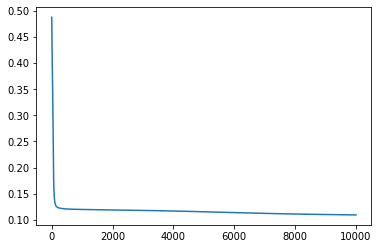

In [23]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = CVaRLoss(a=0.75, inverted=True)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

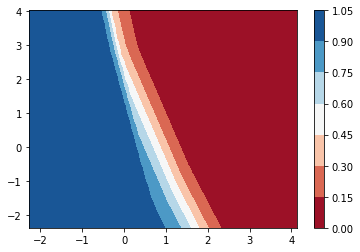

In [24]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

0.95, inverted

Num losses > 0.4: (1, 1298)


(0.0, 2000.0)

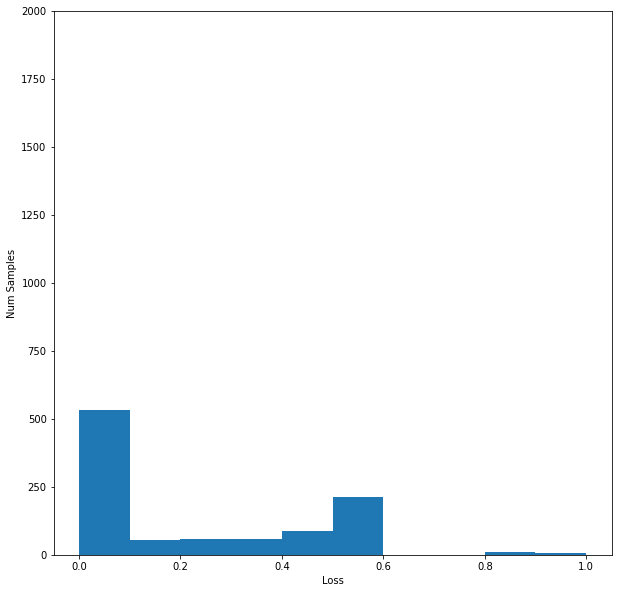

In [25]:
criterion = nn.CrossEntropyLoss(reduction='none')

losses = []
with torch.no_grad():
    output = model(inputs)
    loss = criterion(output, labels_orig.squeeze(1).type(torch.LongTensor))
    print('Num losses > 0.4:', np.array(np.where(loss > 0.4)).shape)
    losses.append(loss)

plt.figure(figsize=(10,10))
plt.xlabel('Loss')
plt.ylabel('Num Samples')
plt.hist(losses, range=[0.0, 1])
plt.ylim((None, 2000))

# Some Classification

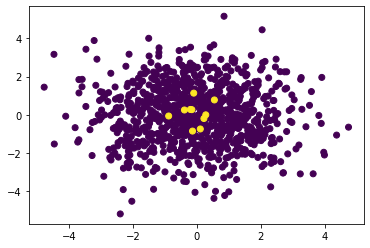

In [26]:
n_samples_1 = 1000
n_samples_2 = 10
centers = [[0.0, 0.0], [0, 0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

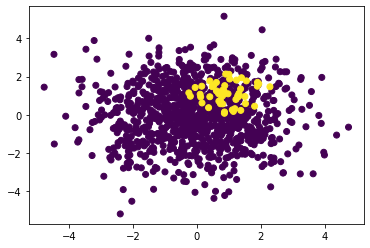

In [13]:
n_samples_1 = 1000
n_samples_2 = 50
centers = [[0.0, 0.0], [1.0, 1.0]]
clusters_std = [1.5, 0.5]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

plt.scatter(X[:,0], X[:,1], c=y)

y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

0.5640816688537598
0.00012056664854753762
6.100121026975103e-05
4.023897054139525e-05
2.9818273105775006e-05
2.3564825823996216e-05
1.9418874217080884e-05
1.6498330296599306e-05
1.4309704056358896e-05
1.2607434655365068e-05
Final loss:  1.1267548870819155e-05


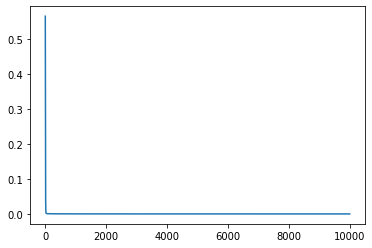

In [27]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = CVaRLoss(a=0.05, inverted=True)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

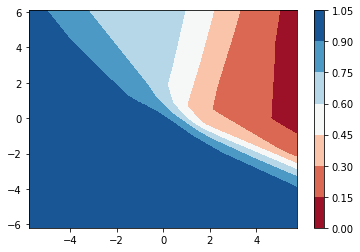

In [28]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# XOR Classification

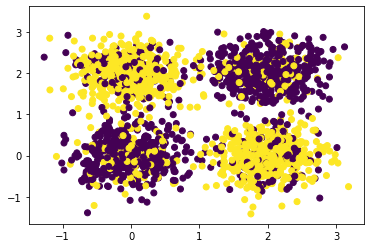

In [16]:
n_samples_1 = 500
n_samples_2 = 500
n_samples_3 = 500
n_samples_4 = 500
centers = [[0.0, 0.0], [0.0, 2.0], [2.0, 2.0], [2.0, 0.0]]
clusters_std = [0.4, 0.4, 0.4, 0.4]
X, y = make_blobs(n_samples=[n_samples_1, n_samples_2, n_samples_3, n_samples_4],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state = SEED,
                  shuffle=False)

# Set diagnoals to be the same class
y = y % 2

# Randomly flip a percentage of labels
percent = 0.2
n = len(y)
y_orig = np.array(list(y))
y = np.array([abs(1 - y[i]) if i in random.sample(range(n), int(percent * n)) else y[i] for i in range(n)])

plt.scatter(X[:,0], X[:,1], c=y)

y_orig = y_orig.reshape(-1, 1)
y = y.reshape(-1, 1)
inputs = torch.tensor(X, dtype=torch.float)
labels_orig = torch.tensor(y_orig, dtype=torch.float)
labels = torch.tensor(y, dtype=torch.float)

0.1655340939760208
0.0001502235681982711
7.330671360250562e-05
4.7717185225337744e-05
3.509490124997683e-05
2.7627156669041142e-05
2.2704816728946753e-05
1.9233391867601313e-05
1.665178751864005e-05
1.4663803085568361e-05
Final loss:  1.3087620573060121e-05


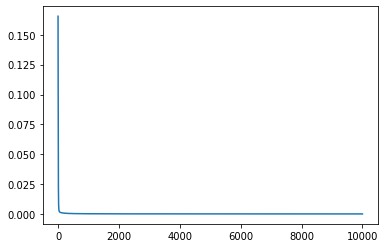

In [17]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

criterion = CVaRLoss(a=0.05, inverted=True)

model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)

    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print(loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

0.8255149722099304
0.5345418453216553
0.5314754843711853
0.528815507888794
0.5242512822151184
0.5217906832695007
0.5199196338653564
0.518709659576416
0.5179026126861572
0.5173919796943665
Final loss:  0.5170165300369263


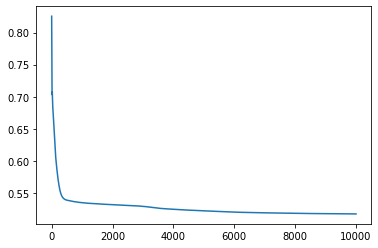

In [18]:
# Reset random seeds for comparaison.
SEED = 15
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
    

criterion = nn.CrossEntropyLoss()
model = TwoLayerMLP(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.squeeze(1).type(torch.LongTensor))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final loss: ", losses[-1])
plt.plot(losses)

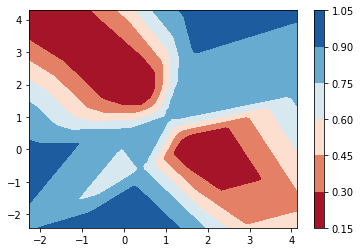

In [19]:
# define bounds of the domain
min1, max1 = X[:, 0].min() - 1, X[:, 0].max() + 1
min2, max2 = X[:, 1].min() - 1, X[:, 1].max() + 1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

pred = F.softmax(model.forward(torch.tensor(grid, dtype=torch.float)), dim=1)
pred = pred.detach().numpy()

# keep probabilities for class 0
pred = pred[:, 0]
# reshape the predictions back into a grid
zz = pred.reshape(xx.shape)

# plot the grid of x, y and z values as a surface
c = plt.contourf(xx, yy, zz, cmap='RdBu')
# add a legend, called a color bar
plt.colorbar(c)

# Fair Regression

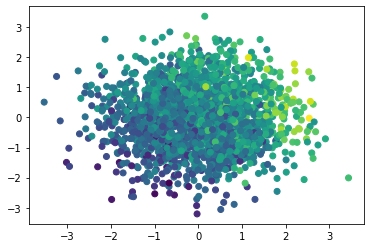

In [25]:
num_train = 2000
DATA_DIM = 5

X_train = np.random.normal(loc=0, scale=1, size=(num_train, DATA_DIM))
eps_train = np.random.normal(loc=0, scale=0.01, size=(num_train, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
y_train = np.array([X_train[i].dot(theta) + eps_train[i] if X_train[i][0] <= 1.645 else X_train[i].dot(theta) + X_train[i][0] + eps_train[i] for i in range(num_train)])

plt.scatter(X_train[:,0], X_train[:,1], c=y_train)

y_train = y_train.reshape(-1, 1)
inputs = torch.tensor(X_train, dtype=torch.float)
labels = torch.tensor(y_train, dtype=torch.float)

In [26]:
num_test = 20000

X_test = np.random.normal(loc=0, scale=1, size=(num_test, DATA_DIM))
eps_test = np.random.normal(loc=0, scale=0.01, size=(num_test, 1))

theta = np.array([1 for _ in range(DATA_DIM)])
is_majority = [False if X_test[i][0] > 1.645 else True for i in range(num_test)]
y_test = np.array([X_test[i].dot(theta) + eps_test[i] if X_test[i][0] <= 1.645 else X_test[i].dot(theta) + X_test[i][0] + eps_test[i] for i in range(num_test)])
y_test = y_test.reshape(-1, 1)

In [27]:
input_size = DATA_DIM
h1 = 50
h2 = 25
epochs = 200

class RegressionMLP(nn.Module):
    def __init__(self, input_size, h1, h2):
        super(RegressionMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

## ERM

In [28]:
SEED = 15

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

5.212076187133789
Final training loss:  0.058227378875017166
Majority Risk: 0.04671740159392357
Minority Risk: 0.4666004478931427


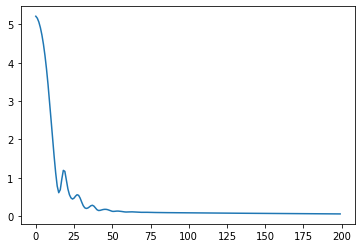

In [29]:
criterion = nn.MSELoss(reduction='mean')

model = RegressionMLP(input_size, h1, h2)
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
losses = []

for epoch in range(epochs):
    # clear the gradients so they wont accumulate
    optimizer.zero_grad()
    
    output = model(inputs)
    # negative likelihood (expected risk)
    loss = criterion(output, labels.type(torch.float32))
    losses.append(loss.item())

    if epoch % 1000 == 0:
        print (loss.item())
        
    # calculate gradient
    loss.backward()
    
    # gradient descent
    optimizer.step()

print("Final training loss: ", losses[-1])
plt.plot(losses)

model.eval()
majority_losses = []
minority_losses = []

with torch.no_grad():
    for i, sample in enumerate(list(zip(X_test, y_test))):
        X, y = sample
        output = model(torch.tensor(X, dtype=torch.float32))
        # negative likelihood (expected risk)
        loss = criterion(output, torch.tensor(y, dtype=torch.float32))
        if is_majority[i]:
            majority_losses.append(loss)
        else:
            minority_losses.append(loss)
            
erm_majority_risk = torch.mean(torch.tensor(majority_losses)).item()
erm_minority_risk = torch.mean(torch.tensor(minority_losses)).item()
print('Majority Risk:', erm_majority_risk)
print('Minority Risk:', erm_minority_risk)

## Inverted CVaR

Final training loss for a=0.05
Majority Risk For a=0.05: 4.65611457824707
Minority Risk For a=0.05: 20.98681640625
Final training loss for a=0.1
Majority Risk For a=0.1: 4.207250595092773
Minority Risk For a=0.1: 20.557329177856445
Final training loss for a=0.15000000000000002
Majority Risk For a=0.15000000000000002: 3.2891533374786377
Minority Risk For a=0.15000000000000002: 16.51806640625
Final training loss for a=0.2
Majority Risk For a=0.2: 1.654680848121643
Minority Risk For a=0.2: 9.416621208190918
Final training loss for a=0.25
Majority Risk For a=0.25: 0.9643632173538208
Minority Risk For a=0.25: 6.209074974060059
Final training loss for a=0.3
Majority Risk For a=0.3: 0.9039922952651978
Minority Risk For a=0.3: 4.779097080230713
Final training loss for a=0.35000000000000003
Majority Risk For a=0.35000000000000003: 0.9236260056495667
Minority Risk For a=0.35000000000000003: 4.684087753295898
Final training loss for a=0.4
Majority Risk For a=0.4: 0.9694682359695435
Minority Risk 

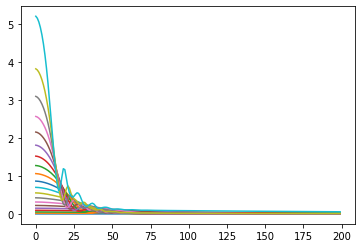

In [33]:
alphas = np.arange(0.05, 1.05, 0.05)

majority_risks = []
minority_risks = []

for a in alphas:
    # Reset random seeds for comparaison.
    SEED = 15
    torch.manual_seed(SEED)
    random.seed(SEED)
    np.random.seed(SEED)

    criterion = CVaRLoss(a=a, inverted=True, criterion=nn.MSELoss(reduction='none'))

    model = RegressionMLP(input_size, h1, h2)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    losses = []

    for epoch in range(epochs):
        # clear the gradients so they wont accumulate
        optimizer.zero_grad()

        output = model(inputs)
        # negative likelihood (expected risk)
        loss = criterion(output.squeeze(1), labels.squeeze(1).type(torch.float32))
        losses.append(loss.item())

        # calculate gradient
        loss.backward()

        # gradient descent
        optimizer.step()

    print("Final training loss for a={}".format(a, losses[-1]))
    plt.plot(losses)

    model.eval()
    majority_losses = []
    minority_losses = []
    
    criterion = nn.MSELoss(reduction='mean')

    with torch.no_grad():
        for i, sample in enumerate(list(zip(X_test, y_test))):
            X, y = sample
            output = model(torch.tensor(X, dtype=torch.float32))
            # negative likelihood (expected risk)
            loss = criterion(output, torch.tensor(y, dtype=torch.float32))
            if is_majority[i]:
                majority_losses.append(loss)
            else:
                minority_losses.append(loss)

    majority_risks.append(torch.mean(torch.tensor(majority_losses)).item())
    minority_risks.append(torch.mean(torch.tensor(minority_losses)).item())
    
    print('Majority Risk For a={}: {}'.format(a, majority_risks[-1]))
    print('Minority Risk For a={}: {}'.format(a, minority_risks[-1]))

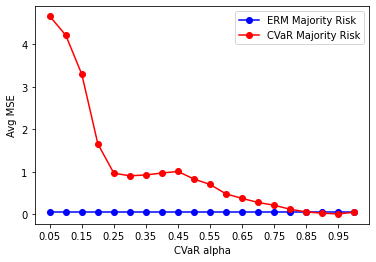

In [34]:
plt.plot(alphas, [erm_majority_risk for _ in range(len(majority_risks))], marker='o', color='b', label='ERM Majority Risk')
plt.plot(alphas, majority_risks, marker='o', color='r', label='CVaR Majority Risk')
plt.xlabel('CVaR alpha')
plt.xticks(np.arange(0.05, 1.05, 0.1))
plt.ylabel('Avg MSE')
plt.legend()

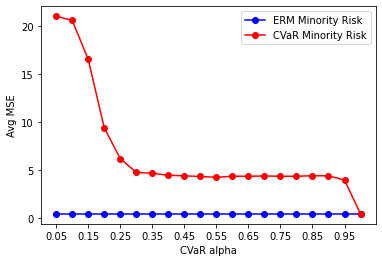

In [35]:
plt.plot(alphas, [erm_minority_risk for _ in range(len(minority_risks))], marker='o', color='b', label='ERM Minority Risk')
plt.plot(alphas, minority_risks, marker='o', color='r', label='CVaR Minority Risk')
plt.xlabel('CVaR alpha')
plt.xticks(np.arange(0.05, 1.05, 0.1))
plt.ylabel('Avg MSE')
plt.legend()